In [75]:
import numpy as np
import cv2
import os
import json
from matplotlib import pyplot as plt
from copy import copy

## Constants

In [76]:
DATASET_DESCRIPTION = "../data/description/data.json"

## Load data

In [77]:
with open(DATASET_DESCRIPTION, "r") as file:
  data_description = json.load(file)
  captures = data_description["captures"]

## Load and show image

In [78]:
def load_image(path: str):
  img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
  return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def plot_images(images: list):
  _, axs = plt.subplots(len(images), figsize=(16, 16*len(images)))
  print(axs)
  if len(images) == 1:
    axs.imshow(images[0], cmap="gray")
  else:
    axs = axs.flatten()
    for img, ax in zip(images, axs):
      ax.imshow(img, cmap="gray")
  plt.show()


In [79]:
original_image = load_image("../examples/not_fit/8_not it.png")

AxesSubplot(0.125,0.125;0.775x0.755)


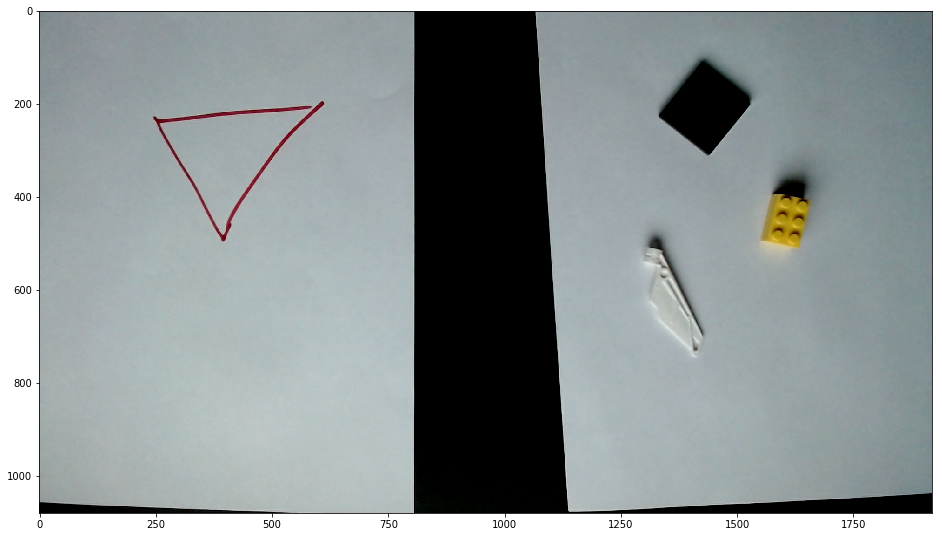

In [80]:
plot_images([original_image])

In [81]:
def process_image(image, image_processors: list):
  for processor in image_processors:
    image = processor(image)

  return image

In [82]:
def process_image_and_plot_image_transformations(image, image_processors: list):
  image_transformations = [image]
  for processor in image_processors:
    image_transformations.append(processor(image_transformations[-1]))

  plot_images(image_transformations)

## Subtract background from original image

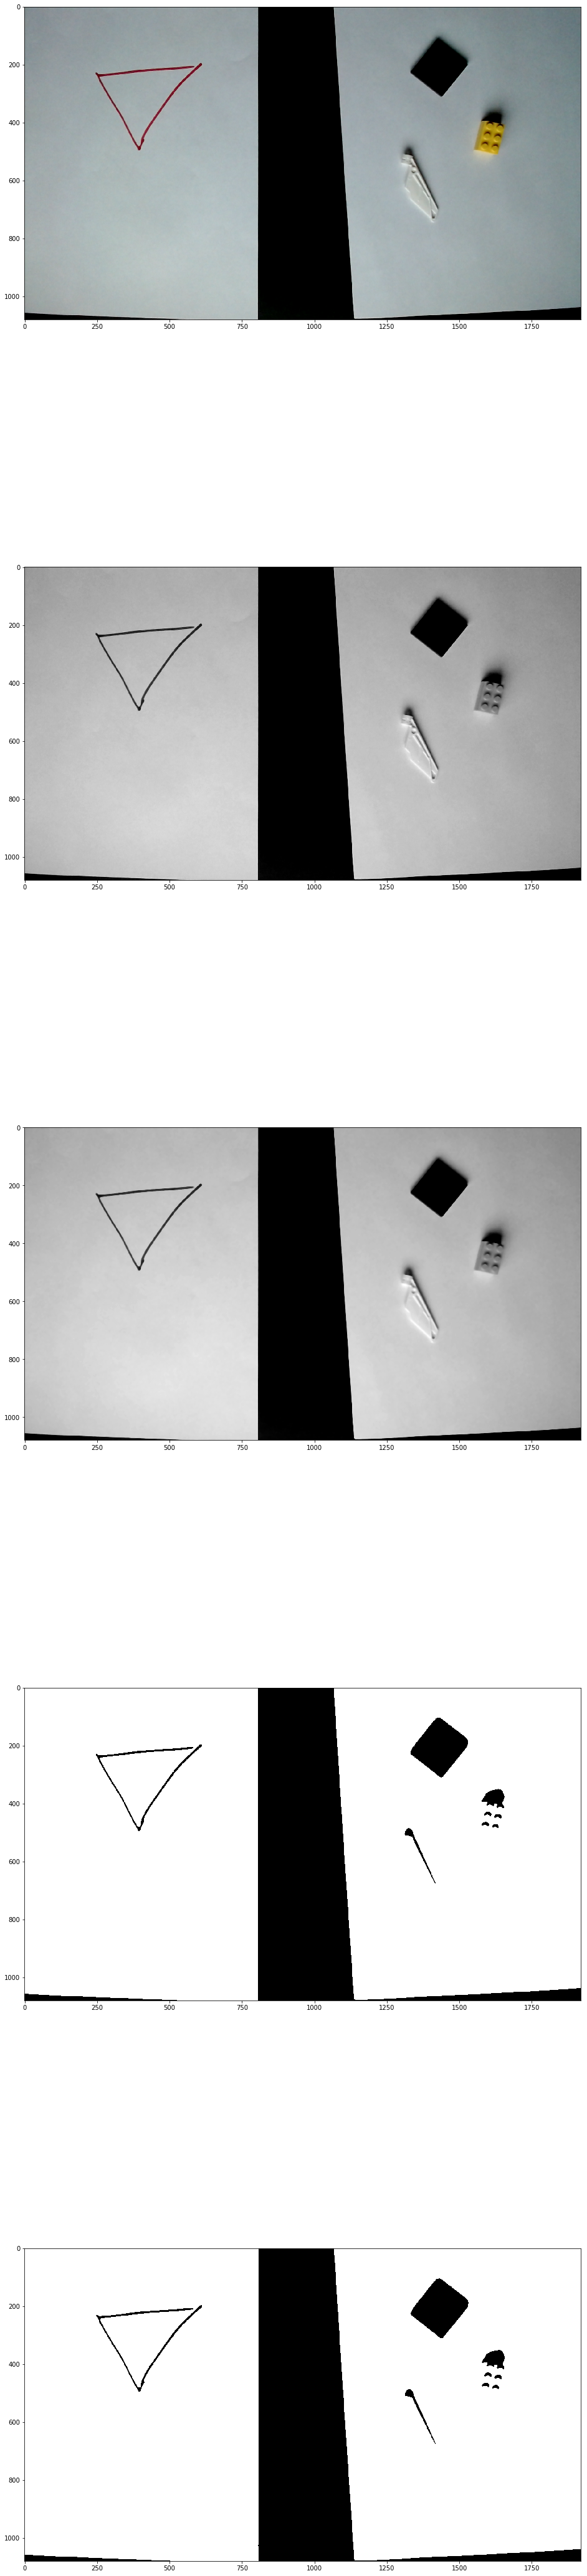

In [83]:
process_pipeline = [
  lambda img: cv2.cvtColor(img, cv2.COLOR_BGR2GRAY),
  lambda img: cv2.medianBlur(img, ksize=7),
  lambda img: cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1],
  lambda img: cv2.morphologyEx(img, cv2.MORPH_OPEN, np.ones((6, 6)))
]

process_image_and_plot_image_transformations(original_image, process_pipeline)

mask = process_image(original_image, process_pipeline)

## Get contour of paper sheets

In [84]:
def get_outer_contours_by_mask(mask):
  contours, _ = cv2.findContours(copy(mask), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  return contours

In [85]:
def get_bboxes_by_mask(mask):
  return [cv2.boundingRect(contour) for contour in get_outer_contours_by_mask(mask)]

In [86]:
def draw_contours(image, contours):
  image = copy(image)
  cv2.drawContours(image, contours, -1, (0, 0, 255), 3)
  return image

In [87]:
def draw_bboxes(image, bboxes):
    image = copy(image)
    for i, (x, y, w, h) in enumerate(bboxes):
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 0, 255), 3)
        cv2.putText(image, f'{i}', (x, y+h), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), thickness=5)

    return image

AxesSubplot(0.125,0.125;0.775x0.755)


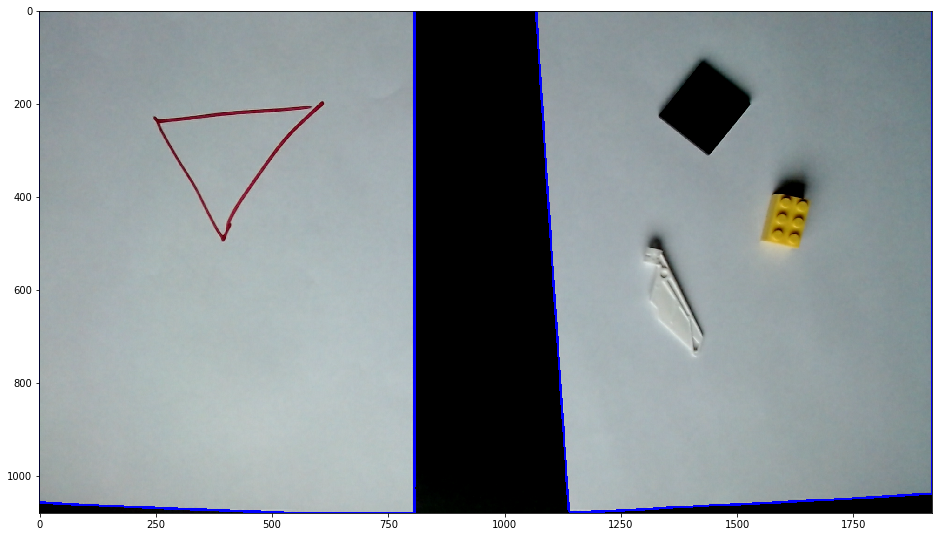

In [88]:
plot_images([draw_contours(original_image, get_outer_contours_by_mask(mask))])

## Get masks of paper sheets

In [89]:
def get_mask_by_contour(image, contour):
  mask = np.zeros_like(image)
  cv2.fillPoly(mask, [contour], (255, 255, 255))
  return mask

def get_papers_masks(image, mask):
  contours = get_outer_contours_by_mask(mask)
  assert len(contours) > 0
  if len(contours) == 1:
    return [get_mask_by_contour(image, contours[0])]

  papers_contours = list(sorted(contours, key=lambda contour: cv2.contourArea(contour))[-2:])
  paper_contours_from_left_to_right = list(sorted(papers_contours, key=lambda contour: cv2.boundingRect(contour)[0]))

  return tuple([get_mask_by_contour(image, contour) for contour in paper_contours_from_left_to_right])

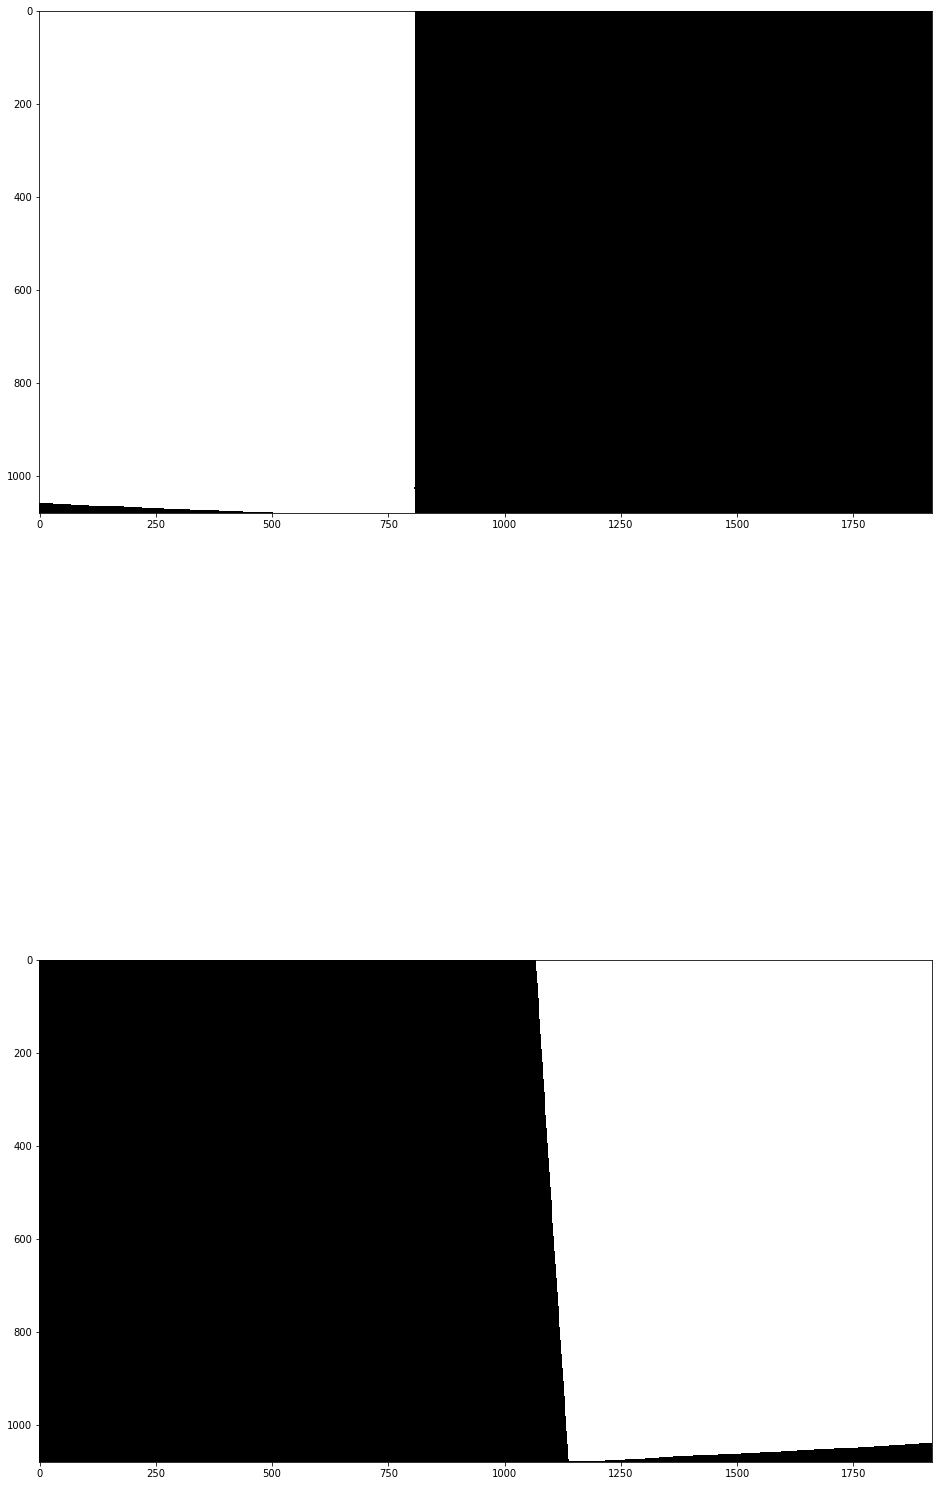

In [90]:
plot_images(get_papers_masks(original_image, mask))

## Separate left and right paper sheets

In [91]:
def apply_mask(image, mask):
  mask_boolean = mask != (255, 255, 255)
  if image.ndim == 2:
    mask_channels = [mask_boolean[:, :, i] for i in (0, 1, 2)]
    mask_boolean = np.logical_or(*mask_channels)

  return np.where(mask_boolean, 0, image)

In [92]:
image_papers_separated = [apply_mask(original_image, paper_mask) for paper_mask in get_papers_masks(original_image, mask)]

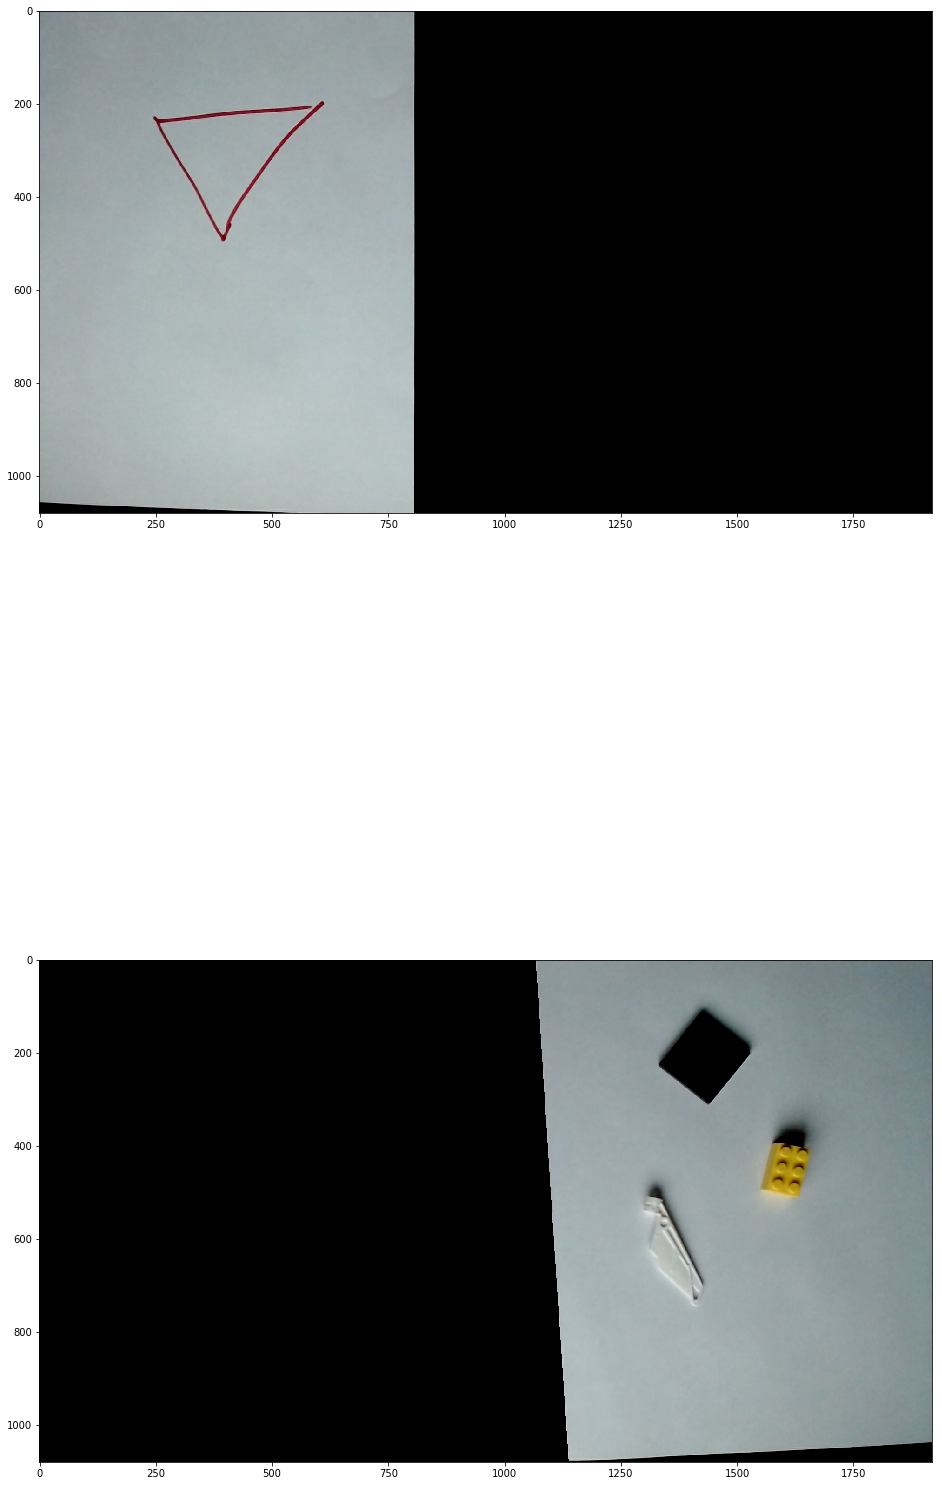

In [93]:
plot_images(image_papers_separated)

## Process left paper sheet (one with the area)

In [94]:
paper_mask_left, paper_mask_right = get_papers_masks(original_image, mask)
image_paper_left, image_paper_right = image_papers_separated

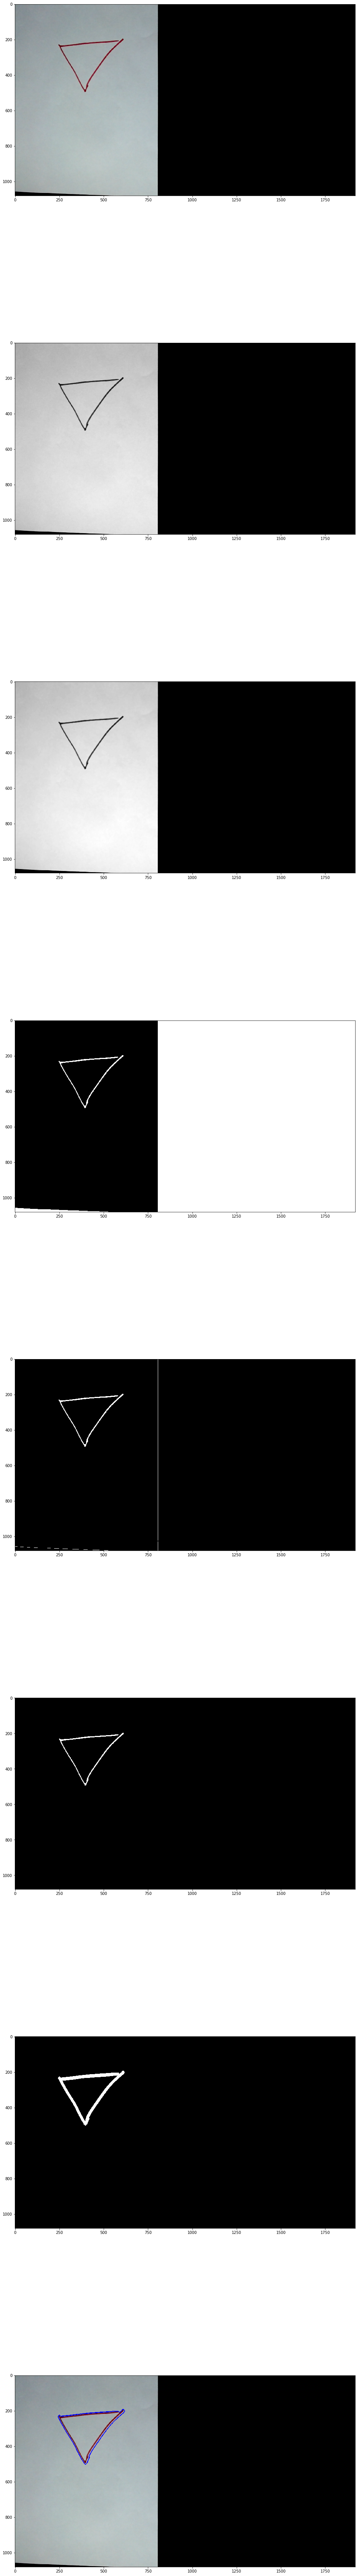

In [95]:
dilate_kernel = np.asarray([
  [0, 0, 1, 0, 0],
  [0, 1, 1, 1, 0],
  [1, 1, 1, 1, 1],
  [0, 1, 1, 1, 0],
  [0, 0, 1, 0, 0]
], dtype=np.uint8)

def process_left_paper(image_paper_left, paper_mask_left):
  left_paper_processors = [
    lambda img: cv2.cvtColor(img, cv2.COLOR_BGR2GRAY),
    lambda img: cv2.medianBlur(img, ksize=7),
    lambda img: cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1],
    lambda mask: apply_mask(mask, paper_mask_left),
    lambda mask: cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel=np.ones((2, 2)), iterations=2),
    lambda mask: cv2.dilate(mask, dilate_kernel, iterations=3),
    lambda mask: draw_contours(image_paper_left, get_outer_contours_by_mask(mask))
  ]
  process_image_and_plot_image_transformations(image_paper_left, left_paper_processors)

process_left_paper(image_paper_left, paper_mask_left)


## Process the right paper (with the objects), get approximate contours for them (no need to be exact, since we'll just cut a 256x256 parts of the image with that contours)

Extract mask for white objects based on statistic of hue

In [96]:
def get_mask_by_hue_MAD(image, known_mask_value=0):
    image_hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)

    def get_MAD_objects_mask_for_channel(img, channel_idx, filter_value):
      img = copy(img)
      img_channel = img[:, :, channel_idx]
      img_channel_filtered = img_channel[img_channel != filter_value]

      median = np.median(img_channel_filtered)
      mad = np.median(np.abs(img_channel_filtered - median))

      mask = np.zeros_like(img_channel)
      mask[np.where(np.logical_and(np.abs(img_channel  - median) > 5 * mad, img_channel != filter_value))] = 1
      return mask

    mask = get_MAD_objects_mask_for_channel(image_hls, channel_idx=0, filter_value=known_mask_value)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel=np.ones((12, 12)))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel=np.ones((30, 30)))
    return mask

In [97]:
def process_right_paper(image_paper_right, paper_mask_right):
  hue_mask = get_mask_by_hue_MAD(image_paper_right, 0)
  def apply_hue_mask(mask):
    mask[hue_mask == 1] = 255
    return mask

  right_paper_processors = [
    lambda img: cv2.medianBlur(img, ksize=11),
    lambda img: cv2.cvtColor(img, cv2.COLOR_BGR2GRAY),
    lambda img: cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1],
    lambda mask: apply_mask(mask, paper_mask_right),
    lambda mask: cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel=np.ones((2, 2)), iterations=2),
    lambda mask: cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel=np.ones((50, 50))),
    lambda mask: cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel=np.ones((3, 3))),
    lambda mask: apply_hue_mask(mask),
    lambda mask: draw_contours(image_paper_right, get_outer_contours_by_mask(mask))
  ]
  process_image_and_plot_image_transformations(image_paper_right, right_paper_processors)

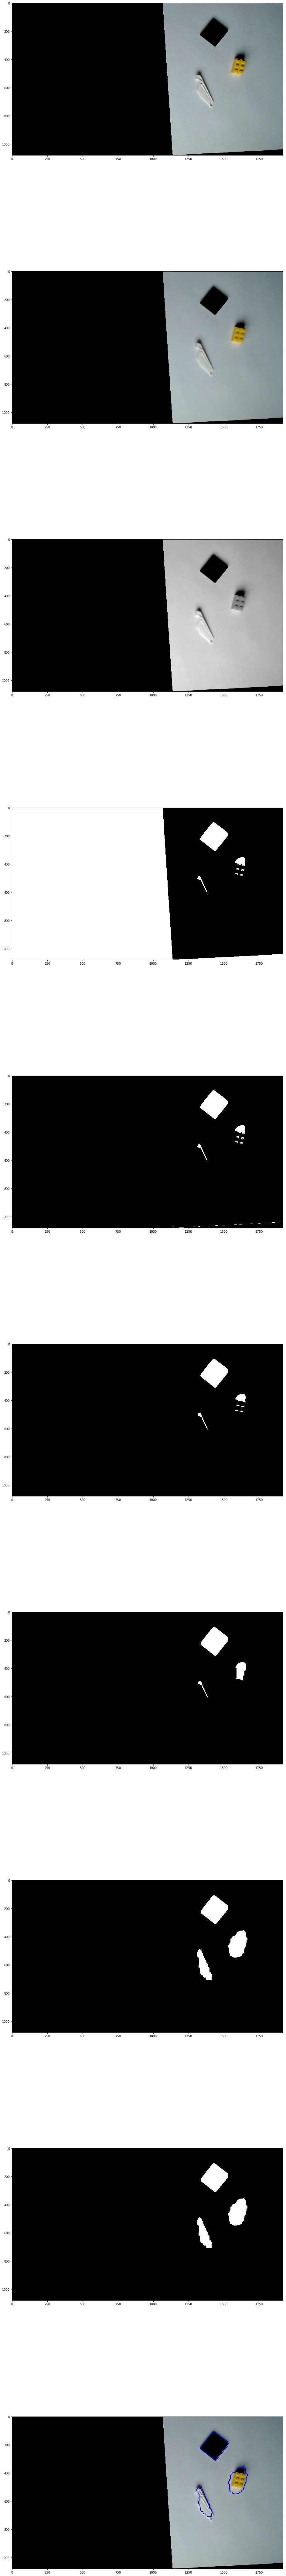

In [98]:
process_right_paper(image_paper_right, paper_mask_right)